# Crop Disease Classification with CNN

![alt text](images/5362701_SMPT.pjg)

##  Project Overview

Crop diseases are a leading cause of reduced agricultural productivity.  
This notebook builds a Convolutional Neural Network (CNN) to classify crop diseases from leaf images.

##  Objectives

- Load and preprocess image data
- Build and train a CNN model
- Evaluate model performance
- Save the trained model for deployment

##  Dataset

- Dataset: **PlantVillage**
- Classes:
    - Healthy
    - Rust
    - Blight
- Images size: 128x128 pixels
- Data split:
    - Training set: X images
    - Validation set: Y images
    - Test set: Z images

##  Libraries Used

- TensorFlow / Keras
- NumPy
- Matplotlib
- Scikit-learn

## Data Loading & Preprocessing


In [567]:
# Importing libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

# Set seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Data Loading

In [569]:
# Loading the data
dataset_path = "PlantVillage"
data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)
class_names = data.class_names
num_classes = len(class_names)
num_classes

Found 20638 files belonging to 15 classes.


15

## Basic EDA (Exploratory Data Analysis) on dataset

In [571]:
# Finding out how many imags are in each folder
import os

counts = {}
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        count = len(os.listdir(folder_path))
        counts[folder] = count

# Display results
for cls, count in counts.items():
    print(f"{cls}: {count} images")

Pepper__bell___Bacterial_spot: 997 images
Pepper__bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___healthy: 152 images
Potato___Late_blight: 1000 images
Tomato_Bacterial_spot: 2127 images
Tomato_Early_blight: 1000 images
Tomato_healthy: 1591 images
Tomato_Late_blight: 1909 images
Tomato_Leaf_Mold: 952 images
Tomato_Septoria_leaf_spot: 1771 images
Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
Tomato__Target_Spot: 1404 images
Tomato__Tomato_mosaic_virus: 373 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 3209 images


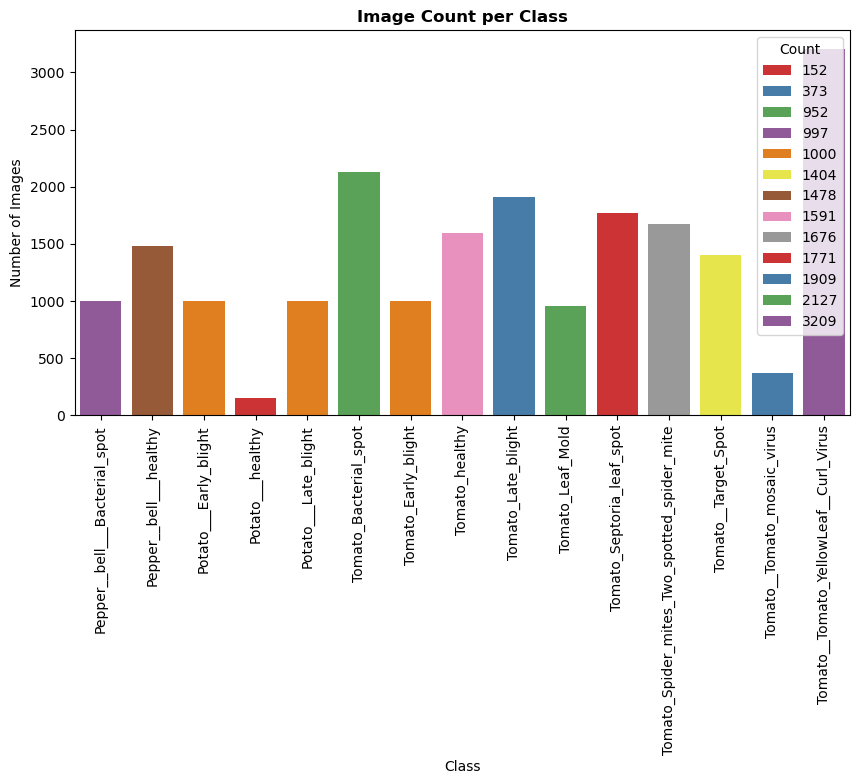

In [572]:
# Ploting a distribution for the classes
counts_df = pd.DataFrame({
    "Class": list(counts.keys()),
    "Count": list(counts.values())
})
    
plt.figure(figsize=(10,5))
sns.barplot(data=counts_df, x="Class", y="Count",hue = 'Count', palette="Set1")
plt.xticks(rotation=90)
plt.title("Image Count per Class", weight = 'bold')
plt.ylabel("Number of Images")
plt.show()

## Visualize Sample Images


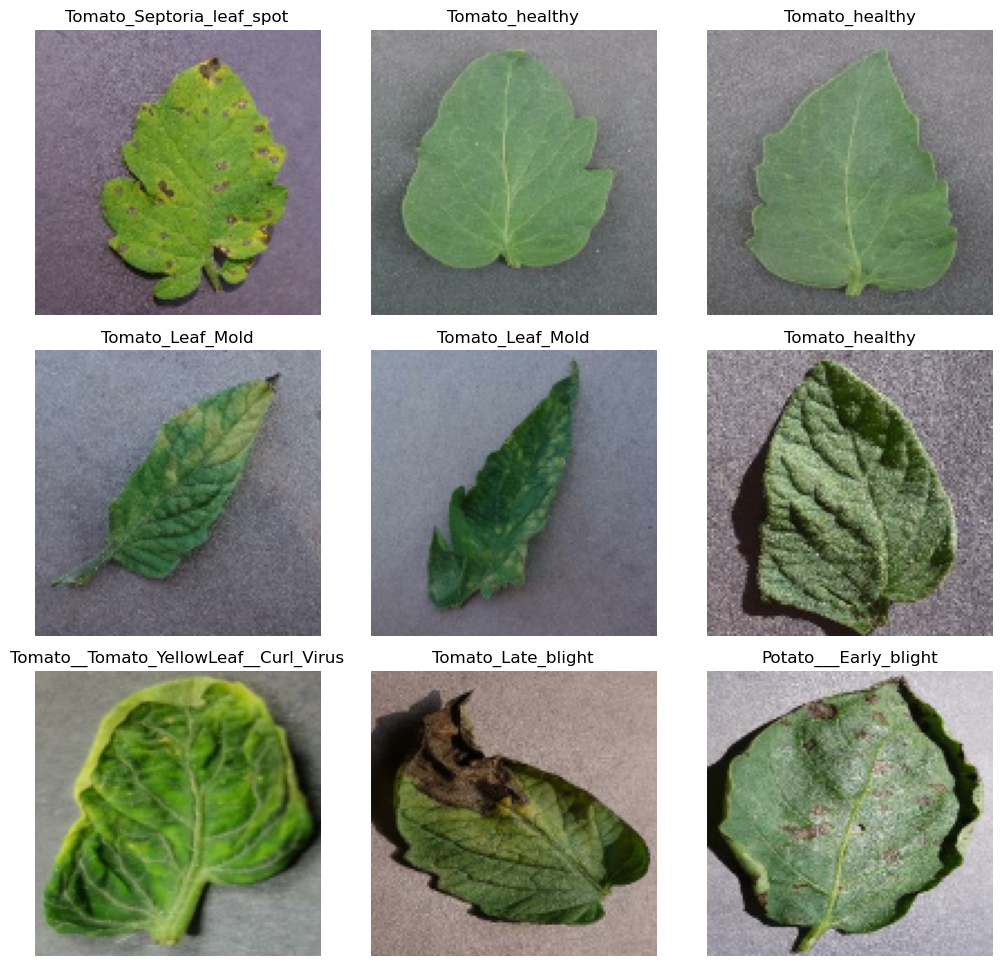

In [574]:
for images, labels in data.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_idx = np.argmax(labels[i])
        plt.title(class_names[class_idx])
        plt.tight_layout()
        plt.axis("off")

In [575]:
# Checking image size
from PIL import Image

image_sizes = []

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    for img_file in os.listdir(class_path)[:10]:  # limit to 10 per class for speed
        img_path = os.path.join(class_path, img_file)
        with Image.open(img_path) as img:
            image_sizes.append(img.size)

# Convert to DataFrame for EDA
sizes_df = pd.DataFrame(image_sizes, columns=["Width", "Height"])
print(sizes_df.describe())

       Width  Height
count  150.0   150.0
mean   256.0   256.0
std      0.0     0.0
min    256.0   256.0
25%    256.0   256.0
50%    256.0   256.0
75%    256.0   256.0
max    256.0   256.0


## Preprocessing

## Spliting to test and validations

In [578]:
# Trainset

original_train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)

# Vaidation set

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)

Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.


### Rescale Pixels

In [580]:
# Rescaling/Normalization
normalization_layer = layers.Rescaling(1./255)

train_ds = original_train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

### Data Augmentation

Data augmentation creates new images from your existing ones, helping reduce overfitting.


In [583]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Apply augmentation during training
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

### Prefetching

Speed up our pipeline by prefetching  our data

In [586]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

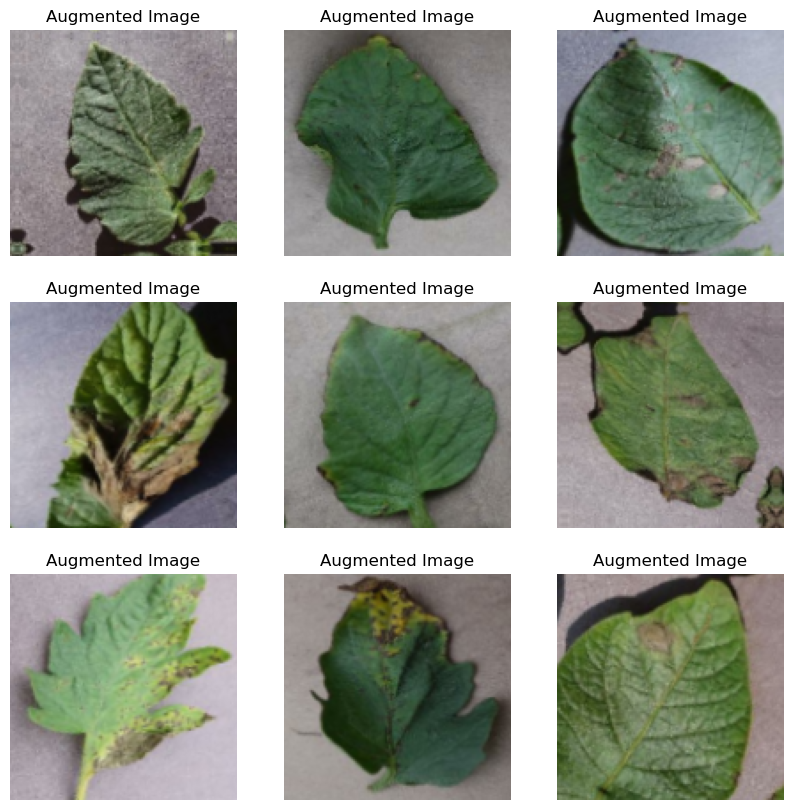

In [587]:
# Checking our preprocessed data
for images, labels in augmented_train_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title("Augmented Image")
        plt.axis("off")

In [588]:
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)


Images shape: (32, 128, 128, 3)
Labels shape: (32, 15)


# Modeling

In [590]:
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [591]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,575 (12.61 MB)

 Trainable params: 3,306,575 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [592]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 219s 415ms/step - accuracy: 0.3482 - loss: 2.0327 - val_accuracy: 0.7274 - val_loss: 0.8090
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 265s 420ms/step - accuracy: 0.6747 - loss: 1.0062 - val_accuracy: 0.8205 - val_loss: 0.5250
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 200s 386ms/step - accuracy: 0.7207 - loss: 0.8409 - val_accuracy: 0.8379 - val_loss: 0.4699
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 205s 397ms/step - accuracy: 0.7768 - loss: 0.6730 - val_accuracy: 0.8616 - val_loss: 0.4143
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 198s 384ms/step - accuracy: 0.8092 - loss: 0.5688 - val_accuracy: 0.8788 - val_loss: 0.3595
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 211s 401ms/step - accuracy: 0.8300 - loss: 0.5021 - val_accuracy: 0.8878 - val_loss: 0.3217
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 202s 391ms/step - accuracy: 0.8552 - loss: 0.4199 - val_accuracy: 0.8883 - val_loss: 0.3151
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 204s 394ms/step - accuracy: 0.8695 -

## Model evaluation

In [594]:
# Evalute how the model performs across all validations
loss, accuracy = model.evaluate(train_ds)
print("Train Loss:", loss)
print("Train Accuracy:", accuracy)
print()
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

516/516 ━━━━━━━━━━━━━━━━━━━━ 52s 101ms/step - accuracy: 0.9755 - loss: 0.0782
Train Loss: 0.06999358534812927
Train Accuracy: 0.9795893430709839

129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.9167 - loss: 0.2431
Validation Loss: 0.2565278708934784
Validation Accuracy: 0.9159195423126221


- From the evaluations we can se that our model performs rather well with an accuracy of 0.92 and a loss function of 0.2467

## Ploting the model performance

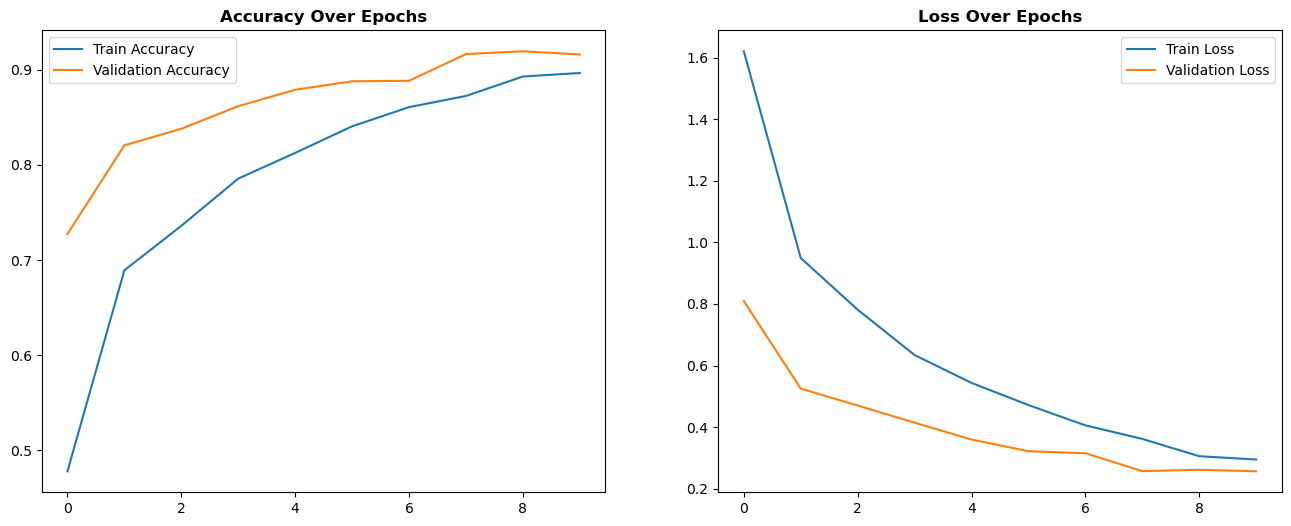

In [597]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Accuracy Over Epochs', weight = 'bold')
axs[0].legend()

# Loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Loss Over Epochs', weight = 'bold')
axs[1].legend()

plt.show()

### Confussion Matrix

## Making Predictions

In [600]:
# Take one batch from validation set
for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    
    # Get predicted classes
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)
    
    print("Predicted:", predicted_classes)
    print("Actual:", true_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Predicted: [12  1 12 11  3 11  2 10 12  9 12  8 10  5 13  5 10  1  5  9 12  9 12  0
  7  9  7 11 14  3  7  8]
Actual: [12  1 12 11  3 11  2 10 12  9 12  8 10  5 13 11 10  1  5  9 12  9 12  0
  6  9  7 11 14  3  7  7]


In [601]:
# Get class names
class_names = original_train_ds.class_names

# Print class names instead of numeric labels
for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_names = [class_names[i] for i in predicted_classes]
    true_names = [class_names[i] for i in true_classes]

    print("Predicted class names:", predicted_names)
    print()
    print("Actual class names:", true_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Predicted class names: ['Tomato__Target_Spot', 'Tomato_healthy', 'Tomato_Early_blight', 'Tomato_Early_blight', 'Tomato_Bacterial_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Pepper__bell___healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Pepper__bell___healthy', 'Potato___Late_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Pepper__bell___healthy', 'Pepper__bell___healthy', 'Tomato_Leaf_Mold', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Potato___Late_blight', 'Tomato_Late_blight', 'Pepper__bell___healthy', 'Tomato_Septoria_leaf_spot', 'Pepper__bell___Bacterial_spot', 'Tomato_healthy', 'Potato___Late_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Late_blight', 'Pep

# NATURAL LANGUAGE PROCESSING

For this project we are also considering famers who might not have access cameras or might have a hard time navigating to where an image is located.

For this giving descriptions of how the crop looks like might help this kind of famers by giving a description and our **NLP** model predicts if the crop disease that might be affecting that crop


Scince we did not have access to actual collected descriptions of the crops in our dataset we opted to synthesize 1751 records of actual discriptions from the internet which is in the ***crop_descripton.ipynb*** file and saved it in ***synthetic_data.csv*** file.

The process involved having a dictonary of descriptions for each class and yousing adjectives and prefrixes so that the data did not have many duplicates. Out of 1751 records only 13 are duplicated.

## Loading, Cleaning and Data Exploration

In [606]:
# Library Importations
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [607]:
des_df = pd.read_csv('synthetic_data.csv')
des_df.head()

,description,crop,status,disease,recommended_pesticide
0,rapid Plant vigor declines noticeably. sudden ...,Tomato,Unhealthy,Spider_mites_Two_spotted_spider_mite,Bacillus subtilis
1,Agronomist notes: moderate Stems show brown st...,Potato,Unhealthy,Late_blight,Biological predators
2,Visual check indicates: rapid Plants maintain ...,Potato,Healthy,healthy,NaN
3,Inspection reveals: extensive Lower leaves dro...,Potato,Unhealthy,Early_blight,Bacillus subtilis
4,Farmer complains: severe Tuber development app...,Potato,Healthy,healthy,NaN


In [608]:
des_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   description            1750 non-null   object
 1   crop                   1750 non-null   object
 2   status                 1750 non-null   object
 3   disease                1750 non-null   object
 4   recommended_pesticide  1410 non-null   object
dtypes: object(5)
memory usage: 68.5+ KB


In [609]:
des_df.duplicated().sum()

9

In [610]:
des_duplicated_df = des_df[des_df.duplicated()]
des_duplicated_df

,description,crop,status,disease,recommended_pesticide
384,Visual check indicates: rapid Older leaves are...,Potato,Unhealthy,Early_blight,Bacillus subtilis
566,Farmer complains: extensive Plant growth slows...,Tomato,Unhealthy,Leaf_Mold,Bacillus subtilis
718,Field observation shows: moderate Webbing may ...,Tomato,Unhealthy,Spider_mites_Two_spotted_spider_mite,Bacillus subtilis
1049,Farmer reports: sudden Lesions become raised a...,Tomato,Unhealthy,Bacterial_spot,Horticultural oil
1312,Agronomist notes: notable Stems are firm and u...,Potato,Healthy,healthy,NaN
1322,Inspection reveals: sudden Leaves yellow aroun...,Potato,Unhealthy,Early_blight,Bacillus subtilis
1330,Field observation shows: moderate Leaves becom...,Potato,Unhealthy,Late_blight,Biological predators
1467,According to the grower: extensive Virus sprea...,Tomato,Unhealthy,Tomato_YellowLeaf_Curl_Virus,Sulfur spray
1669,clear Leaves display mottled light and dark gr...,Tomato,Unhealthy,Tomato_mosaic_virus,Biological predators


In [611]:
des_df = des_df.drop_duplicates()
des_df.duplicated().sum()

0

In [612]:
des_df.shape

(1741, 5)

In [613]:
des_df.isna().sum()

description                0
crop                       0
status                     0
disease                    0
recommended_pesticide    339
dtype: int64

In [614]:
#Replacing None in our pesticide column with No pesticide Required
des_df['pesticide'] = des_df['recommended_pesticide']
des_df = des_df.drop(columns = ['recommended_pesticide'])

des_df = des_df.fillna('No pesticide needed')

In [615]:
des_df.head()

,description,crop,status,disease,pesticide
0,rapid Plant vigor declines noticeably. sudden ...,Tomato,Unhealthy,Spider_mites_Two_spotted_spider_mite,Bacillus subtilis
1,Agronomist notes: moderate Stems show brown st...,Potato,Unhealthy,Late_blight,Biological predators
2,Visual check indicates: rapid Plants maintain ...,Potato,Healthy,healthy,No pesticide needed
3,Inspection reveals: extensive Lower leaves dro...,Potato,Unhealthy,Early_blight,Bacillus subtilis
4,Farmer complains: severe Tuber development app...,Potato,Healthy,healthy,No pesticide needed


## Description Data Analysis

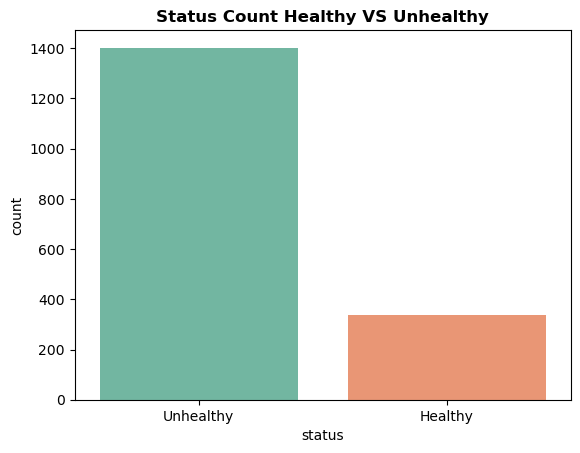

In [617]:
# Count of healthy and Unhealthy status
sns.countplot(x = 'status', data = des_df, hue = 'status', palette = 'Set2')
plt.title('Status Count Healthy VS Unhealthy', weight = 'bold')
plt.show()

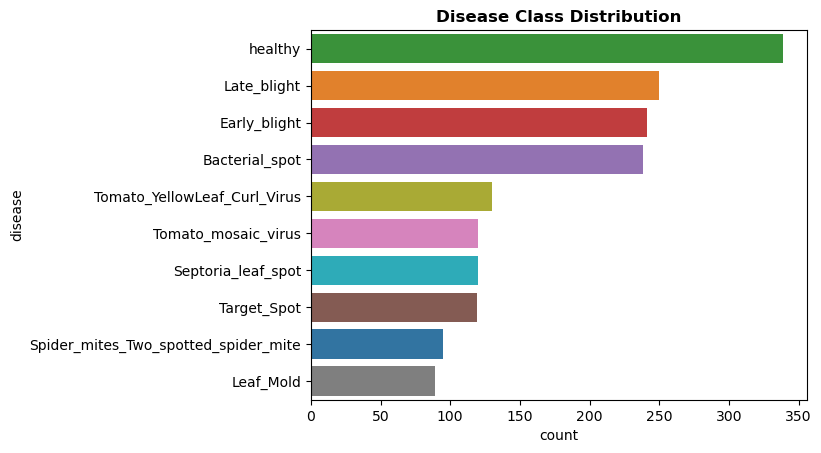

In [618]:
# Dicease Count
sns.countplot(y='disease', data=des_df, order=des_df['disease'].value_counts().index, hue = 'disease')
plt.title('Disease Class Distribution', weight = 'bold')
plt.show()

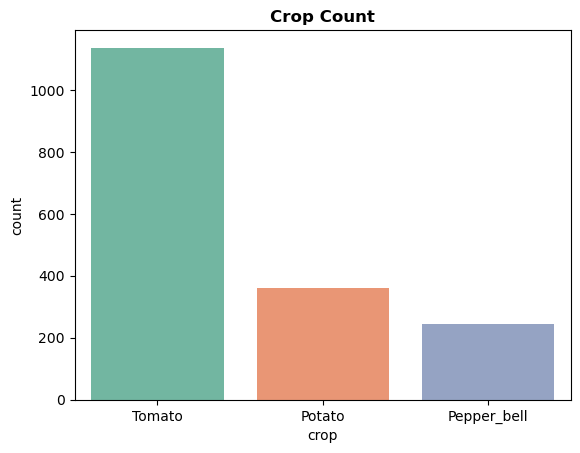

In [619]:
# Crop count
sns.countplot(x = 'crop', data = des_df, hue = 'crop', palette = 'Set2')
plt.title('Crop Count', weight = 'bold')
plt.show()

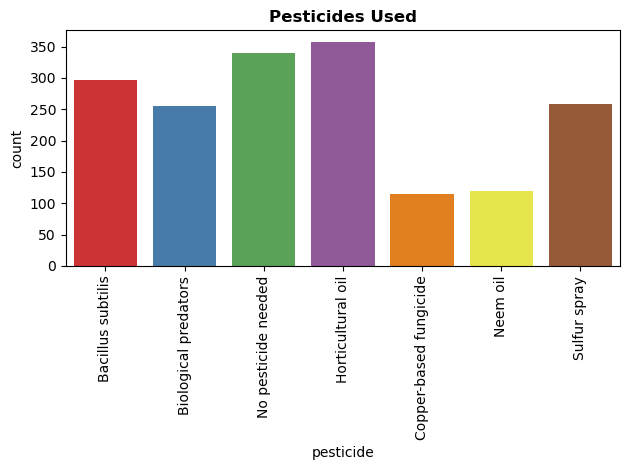

In [620]:
# Pesticide Counts
sns.countplot(x = 'pesticide', data = des_df, hue = 'pesticide', palette = 'Set1')
plt.title('Pesticides Used', weight = 'bold')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

### Text Analysis

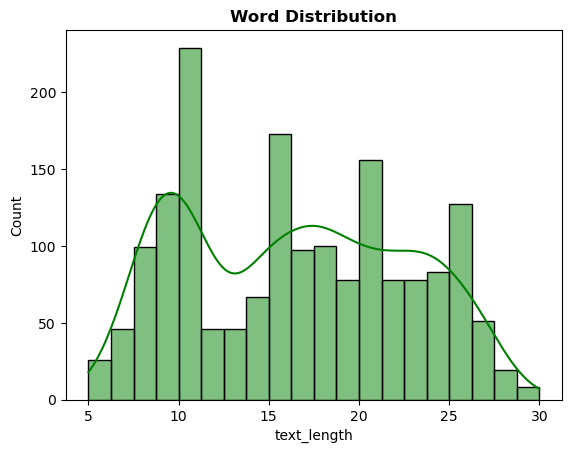

In [622]:
# Histogram of Words
des_df.loc[:, 'text_length'] = des_df['description'].apply(lambda x: len(x.split()))

sns.histplot(des_df['text_length'], bins = 20, kde = True, color = 'green')
plt.title('Word Distribution', weight = 'bold')
plt.show()

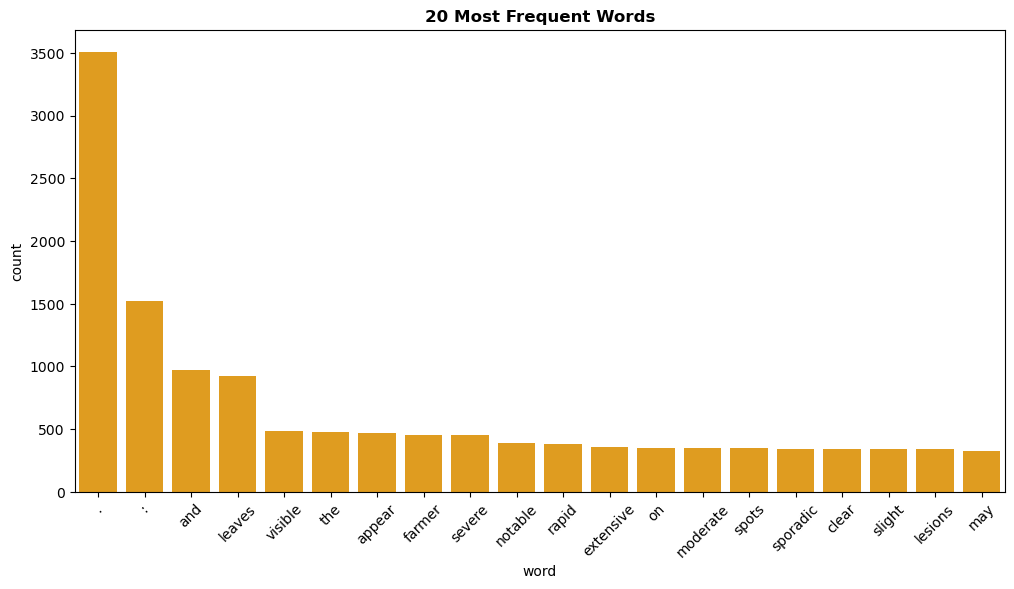

In [623]:
# Most Frequent Words
from collections import Counter

all_words = []

for desc in des_df['description']:
    tokens = word_tokenize(desc.lower())
    all_words.extend(tokens)
word_freq = Counter(all_words)
top_20_words = word_freq.most_common(20)

top_words_df = pd.DataFrame(top_20_words, columns=['word', 'count'])

#Ploting Most Frequent words
plt.figure(figsize=(12,6))
sns.barplot(data=top_words_df, x='word', y='count', color='orange')
plt.title('20 Most Frequent Words', weight='bold')
plt.xticks(rotation=45)
plt.show()

## Feature Engineering

Since our target is the original 15 classes we need to make a new column with those classe with everything falling to where it is supposed to be.

For this we will need to combine our crop and disease column

In [626]:
des_df['target_class'] = des_df['crop'] + '___' + des_df['disease']
des_df['target_class'].head()

0    Tomato___Spider_mites_Two_spotted_spider_mite
1                             Potato___Late_blight
2                                 Potato___healthy
3                            Potato___Early_blight
4                                 Potato___healthy
Name: target_class, dtype: object

In [627]:
des_df.head()

,description,crop,status,disease,pesticide,text_length,target_class
0,rapid Plant vigor declines noticeably. sudden ...,Tomato,Unhealthy,Spider_mites_Two_spotted_spider_mite,Bacillus subtilis,19,Tomato___Spider_mites_Two_spotted_spider_mite
1,Agronomist notes: moderate Stems show brown st...,Potato,Unhealthy,Late_blight,Biological predators,10,Potato___Late_blight
2,Visual check indicates: rapid Plants maintain ...,Potato,Healthy,healthy,No pesticide needed,22,Potato___healthy
3,Inspection reveals: extensive Lower leaves dro...,Potato,Unhealthy,Early_blight,Bacillus subtilis,16,Potato___Early_blight
4,Farmer complains: severe Tuber development app...,Potato,Healthy,healthy,No pesticide needed,22,Potato___healthy


In [628]:
print(f'Null Count: {des_df.isna().sum().sum()}')

print(f'Duplicate Count: {des_df.duplicated().sum()}')

Null Count: 0
Duplicate Count: 0


## Text Preprocessing

In [630]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PINCHEZZ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PINCHEZZ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PINCHEZZ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [631]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lower case for text
    text = text.lower()

    # Clean text by removing special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)
    
    #LLemantization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(tokens)

In [632]:
# Applying our function to our DF
des_df['clean_description'] = des_df['description'].apply(clean_text)

In [633]:
des_df.head()

,description,crop,status,disease,pesticide,text_length,target_class,clean_description
0,rapid Plant vigor declines noticeably. sudden ...,Tomato,Unhealthy,Spider_mites_Two_spotted_spider_mite,Bacillus subtilis,19,Tomato___Spider_mites_Two_spotted_spider_mite,rapid plant vigor decline noticeably sudden we...
1,Agronomist notes: moderate Stems show brown st...,Potato,Unhealthy,Late_blight,Biological predators,10,Potato___Late_blight,agronomist note moderate stem show brown strea...
2,Visual check indicates: rapid Plants maintain ...,Potato,Healthy,healthy,No pesticide needed,22,Potato___healthy,visual check indicates rapid plant maintain st...
3,Inspection reveals: extensive Lower leaves dro...,Potato,Unhealthy,Early_blight,Bacillus subtilis,16,Potato___Early_blight,inspection reveals extensive lower leaf drop p...
4,Farmer complains: severe Tuber development app...,Potato,Healthy,healthy,No pesticide needed,22,Potato___healthy,farmer complains severe tuber development appe...


In [634]:
# Repositioning our target class to be last in our data frame
des_df = des_df[[col for col in des_df.columns if col != 'target_class'] + ['target_class']]

#Checking
des_df.head()

,description,crop,status,disease,pesticide,text_length,clean_description,target_class
0,rapid Plant vigor declines noticeably. sudden ...,Tomato,Unhealthy,Spider_mites_Two_spotted_spider_mite,Bacillus subtilis,19,rapid plant vigor decline noticeably sudden we...,Tomato___Spider_mites_Two_spotted_spider_mite
1,Agronomist notes: moderate Stems show brown st...,Potato,Unhealthy,Late_blight,Biological predators,10,agronomist note moderate stem show brown strea...,Potato___Late_blight
2,Visual check indicates: rapid Plants maintain ...,Potato,Healthy,healthy,No pesticide needed,22,visual check indicates rapid plant maintain st...,Potato___healthy
3,Inspection reveals: extensive Lower leaves dro...,Potato,Unhealthy,Early_blight,Bacillus subtilis,16,inspection reveals extensive lower leaf drop p...,Potato___Early_blight
4,Farmer complains: severe Tuber development app...,Potato,Healthy,healthy,No pesticide needed,22,farmer complains severe tuber development appe...,Potato___healthy


### TF-IDF Vectorization

In [636]:
# Initialize vectorizer
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1,2))

#Fit with clean_description
x_tfidf = tfidf.fit_transform(des_df['clean_description'])

x_tfidf.shape

(1741, 2000)

### Label Encoding

In [638]:
le = LabelEncoder()
y_encoded = le.fit_transform(des_df['target_class'])

# Check for correct mapping
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(class_mapping)

{'Pepper_bell___Bacterial_spot': 0, 'Pepper_bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato___Bacterial_spot': 5, 'Tomato___Early_blight': 6, 'Tomato___Late_blight': 7, 'Tomato___Leaf_Mold': 8, 'Tomato___Septoria_leaf_spot': 9, 'Tomato___Spider_mites_Two_spotted_spider_mite': 10, 'Tomato___Target_Spot': 11, 'Tomato___Tomato_YellowLeaf_Curl_Virus': 12, 'Tomato___Tomato_mosaic_virus': 13, 'Tomato___healthy': 14}


### Train/Test Split

In [640]:
# Spliting our data into train test and split for our model
X_train, X_test, y_train, y_test = train_test_split(x_tfidf, y_encoded, test_size = 0.2, random_state = 42, stratify = y_encoded)

## Modeling

#### Logistic Base Model

In [643]:
# Build and fit thet model
model_0 = LogisticRegression(max_iter=1000)
model_0.fit(X_train, y_train)

# Make predictions
y_preds = model_0.predict(X_test)
y_probs = model_0.predict_proba(X_test)

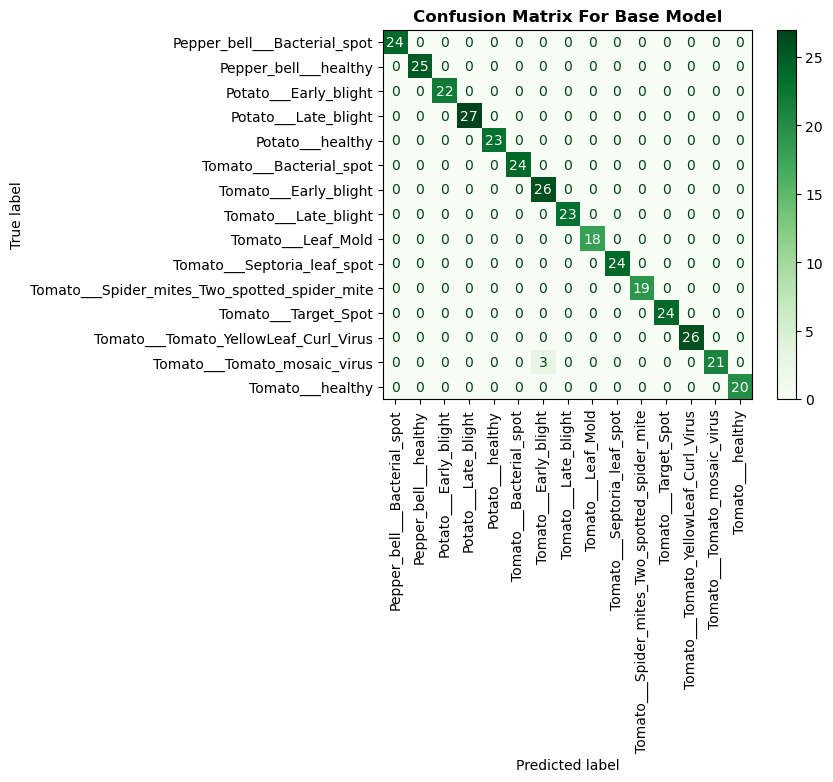

                                               precision    recall  f1-score   support

                 Pepper_bell___Bacterial_spot       1.00      1.00      1.00        24
                        Pepper_bell___healthy       1.00      1.00      1.00        25
                        Potato___Early_blight       1.00      1.00      1.00        22
                         Potato___Late_blight       1.00      1.00      1.00        27
                             Potato___healthy       1.00      1.00      1.00        23
                      Tomato___Bacterial_spot       1.00      1.00      1.00        24
                        Tomato___Early_blight       0.90      1.00      0.95        26
                         Tomato___Late_blight       1.00      1.00      1.00        23
                           Tomato___Leaf_Mold       1.00      1.00      1.00        18
                  Tomato___Septoria_leaf_spot       1.00      1.00      1.00        24
Tomato___Spider_mites_Two_spotted_spider_m

In [644]:
# Evaluate model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=le.classes_)
disp.plot(cmap = 'Greens')
plt.title('Confusion Matrix For Base Model', weight = 'bold')
plt.xticks(rotation = 90)
plt.show()

print(classification_report(y_test, y_preds, target_names=le.classes_))
acc = accuracy_score(y_test, y_preds)
print(f"\nAccuracy: {acc:.4f}")

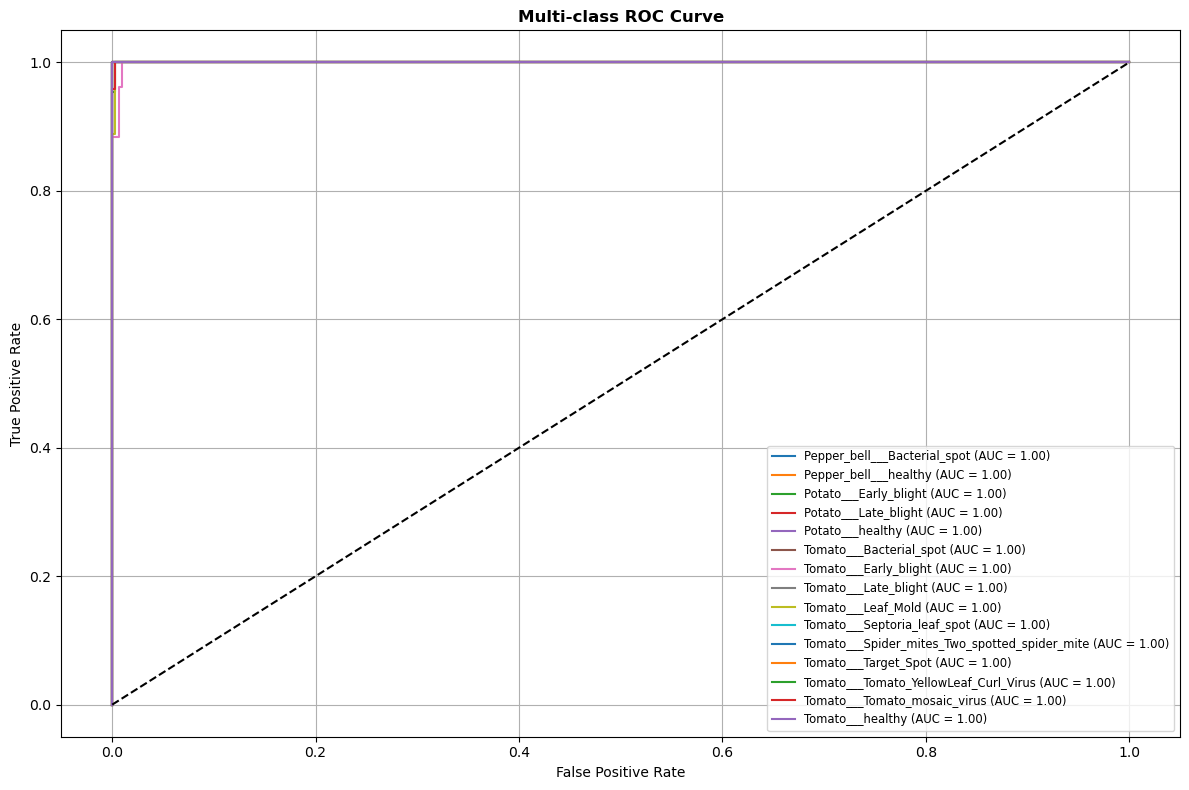

In [645]:
y_test_bin = label_binarize(y_test, classes=list(range(len(le.classes_)))) # Binarize my labels

fpr = {}
tpr = {}
roc_auc = {}

# Loop through each class
for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(12, 8))

for i in range(len(le.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve', weight='bold')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

## Multinomial Naive Bayes Model

In [647]:
#Library importation
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin
import spacy
import joblib

nlp = spacy.load('en_core_web_sm')

In [648]:
# Train_Test_split our data
X_train, X_test, y_train, y_test = train_test_split(
    des_df["clean_description"],
    des_df["target_class"],
    test_size=0.2,
    random_state=42,
    stratify=des_df["target_class"]
)

In [649]:
# Initialize the pipelie
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=2000,
        ngram_range=(1, 2)
    )),
    ('clf', MultinomialNB())
])

In [650]:
# Fit the pipeline on training data
nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=2000, ngram_range=(1, 2))),
                ('clf', MultinomialNB())])

#### Predictions and Evaluations

In [652]:
# Predict on the test set
y_pred = nb_pipeline.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9885386819484241

Classification Report:

                                               precision    recall  f1-score   support

                 Pepper_bell___Bacterial_spot       1.00      1.00      1.00        24
                        Pepper_bell___healthy       1.00      1.00      1.00        25
                        Potato___Early_blight       1.00      1.00      1.00        22
                         Potato___Late_blight       0.96      1.00      0.98        27
                             Potato___healthy       1.00      1.00      1.00        23
                      Tomato___Bacterial_spot       1.00      1.00      1.00        24
                        Tomato___Early_blight       0.90      1.00      0.95        26
                         Tomato___Late_blight       1.00      1.00      1.00        23
                           Tomato___Leaf_Mold       1.00      0.94      0.97        18
                  Tomato___Septoria_leaf_spot       1.00      1.00      1.0

#### Plot Confusion Matrix

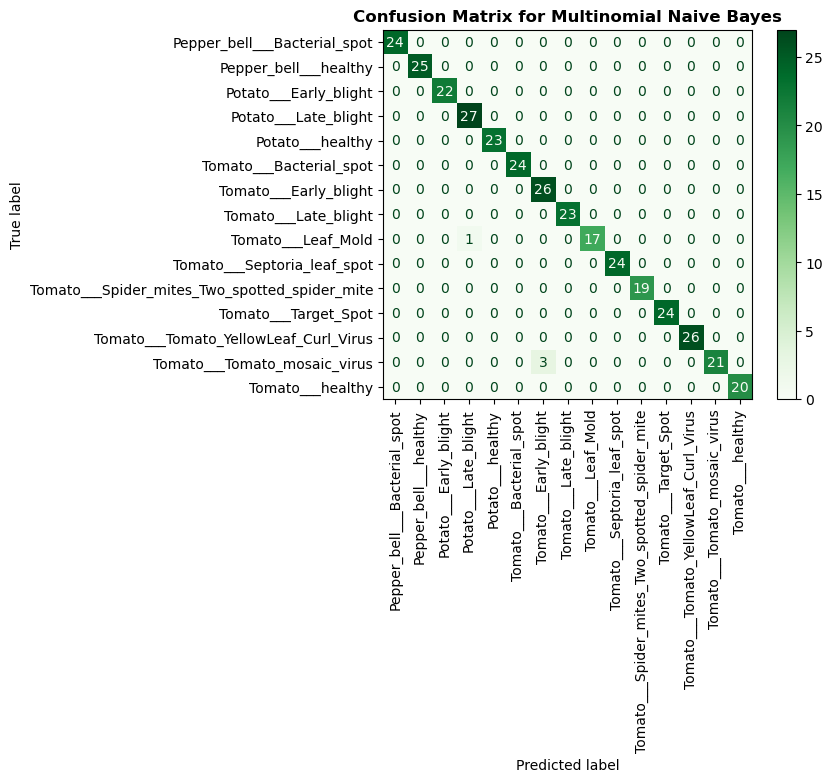

In [654]:
cm = confusion_matrix(y_test, y_pred, labels=nb_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_pipeline.classes_)
disp.plot(xticks_rotation=90, cmap='Greens')
plt.title('Confusion Matrix for Multinomial Naive Bayes', weight='bold')
plt.show()

## Saving Models and Usable Variables

In [656]:
# Saving CNN Model
model.save("model.keras")

#Saving NLP Model
joblib.dump(nb_pipeline, 'mnb_nlp_pipeline.pkl')

['mnb_nlp_pipeline.pkl']